In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path.cwd().parents[0]  # repo root (igs-analysis-baltimore)
RAW  = ROOT / "data_raw"
CLEAN = ROOT / "data_clean"
VIS = ROOT / "visuals"
CLEAN.mkdir(exist_ok=True, parents=True)
VIS.mkdir(exist_ok=True, parents=True)

print("RAW:", RAW.resolve())
print("CLEAN:", CLEAN.resolve())


RAW: /Users/warrenjones/Dev/igs-analysis-baltimore/data_raw
CLEAN: /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean


In [2]:
def read_igs_csv(path: Path) -> pd.DataFrame:
    """
    Reads an IGS export like 'Baltimore_Inclusive_Growth_Score_Data_Export_*.csv'
    The files have 2 meta rows, then a real header row (row 2, zero-indexed 1).
    This function is robust if the vendor ever adds a row 0 'META' line.
    """
    tmp = pd.read_csv(path, header=None)
    # Heuristic: pick the first row that contains 'Census Tract FIPS code'
    header_idx = (
        tmp.index[tmp.apply(lambda r: r.astype(str).str.contains("Census Tract FIPS code", case=False, na=False)).any(axis=1)]
        .tolist()
    )
    if not header_idx:
        # Most files: header is row 1
        header_idx = [1]
    h = header_idx[0]

    header = tmp.iloc[h].astype(str).tolist()
    df = tmp.iloc[h+1:].copy()
    df.columns = (
        pd.Series(header)
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w]+", "_", regex=True)
        .str.strip("_")
    )

    # Standardize key columns if present
    # Expected: 'census_tract_fips_code', 'county', 'state', 'year', 'inclusive_growth_score'
    if "census_tract_fips_code" in df.columns:
        df["geoid"] = df["census_tract_fips_code"].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(11)
    elif "geoid" in df.columns:
        df["geoid"] = df["geoid"].astype(str).str.zfill(11)

    # Year to int if possible
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    # Main score column name (varies slightly)
    score_col_candidates = [c for c in df.columns if c in {"inclusive_growth_score", "score", "igs_score", "overall_score"}]
    if not score_col_candidates:
        raise KeyError(f"Could not find an IGS score column in {path.name}")
    score_col = score_col_candidates[0]
    df.rename(columns={score_col: "inclusive_growth_score"}, inplace=True)

    # Keep the essentials (plus anything helpful if present)
    keep = [c for c in ["geoid", "county", "state", "year", "inclusive_growth_score", "place", "tract_name"] if c in df.columns]
    return df[keep].reset_index(drop=True)


In [3]:
# Find all IGS exports we dropped in data_raw
igs_paths = sorted(RAW.glob("*Inclusive_Growth_Score_Data_Export*.csv"))
assert igs_paths, "No IGS export CSVs found in data_raw. Add them and re-run."

print("IGS files found:")
for p in igs_paths:
    print(" -", p.name)


IGS files found:
 - Baltimore_Inclusive_Growth_Score_Data_Export_03-11-2025_042719.csv
 - Detroit_Inclusive_Growth_Score_Data_Export_03-11-2025_050240.csv
 - Fulton_County_Inclusive_Growth_Score_Data_Export_03-11-2025_052007.csv
 - Inclusive_Growth_Score_Data_Export_03-11-2025_014111.csv
 - Inclusive_Growth_Score_Data_Export_03-11-2025_041223.csv
 - Jackson_Inclusive_Growth_Score_Data_Export_03-11-2025_050326.csv
 - Memphis_Inclusive_Growth_Score_Data_Export_03-11-2025_050434.csv
 - Montgomery_Inclusive_Growth_Score_Data_Export_03-11-2025_050358.csv
 - New_Orleans_Inclusive_Growth_Score_Data_Export_03-11-2025_051415.csv


In [4]:
# You can edit labels here if you add/remove cities
CITY_LABEL_BY_STEM = {
    "Baltimore": "Baltimore",
    "Detroit": "Detroit",
    "Jackson": "Jackson",
    "Birmingham": "Birmingham",
    "Memphis": "Memphis",
    "New_Orleans": "New Orleans",
    "Fulton_County": "South Fulton (proxy: Fulton County)",
    # Add others here if you download more city files
}

# County FIPS for the “home” county of each city label (used for demographics join)
CITY_HOME_COUNTY = {
    "Baltimore": "24510",                    # Baltimore city (independent city treated as county)
    "Detroit": "26163",                      # Wayne County, MI
    "Jackson": "28049",                      # Hinds County, MS
    "Birmingham": "01073",                   # Jefferson County, AL
    "Memphis": "47157",                      # Shelby County, TN
    "New Orleans": "22071",                  # Orleans Parish, LA
    "South Fulton (proxy: Fulton County)": "13121",  # Fulton County, GA
}


In [5]:
all_city_frames = []
for p in igs_paths:
    df = read_igs_csv(p)

    # Infer city label from filename prefix
    stem = p.name.split("_Inclusive_Growth_Score_Data_Export")[0]
    city = CITY_LABEL_BY_STEM.get(stem, stem.replace("_", " "))
    df["city"] = city

    all_city_frames.append(df)

igs = pd.concat(all_city_frames, ignore_index=True)
igs = igs.dropna(subset=["inclusive_growth_score", "year"]).copy()
igs["inclusive_growth_score"] = pd.to_numeric(igs["inclusive_growth_score"], errors="coerce")
igs = igs.dropna(subset=["inclusive_growth_score"]).copy()

print("Rows:", len(igs), "| Cities:", sorted(igs["city"].unique()))
igs.head()


Rows: 12707 | Cities: ['Baltimore', 'Detroit', 'Inclusive Growth Score Data Export 03-11-2025 014111.csv', 'Inclusive Growth Score Data Export 03-11-2025 041223.csv', 'Jackson', 'Memphis', 'Montgomery', 'New Orleans', 'South Fulton (proxy: Fulton County)']


,geoid,county,state,year,inclusive_growth_score,place,city
9,24005403500,Baltimore County,Maryland,2017,56,62,Baltimore
10,24005403500,Baltimore County,Maryland,2018,60,56,Baltimore
11,24005403500,Baltimore County,Maryland,2019,59,52,Baltimore
12,24005403500,Baltimore County,Maryland,2020,58,49,Baltimore
13,24005403500,Baltimore County,Maryland,2021,47,43,Baltimore


In [6]:
# City-year mean (across tracts)
city_year = (
    igs.groupby(["city", "year"], as_index=False)["inclusive_growth_score"]
       .mean()
       .rename(columns={"inclusive_growth_score": "igs_city_mean"})
)

# Averages across windows
avg_2017_2024 = (
    city_year.groupby("city", as_index=False)["igs_city_mean"].mean()
             .rename(columns={"igs_city_mean": "igs_avg_2017_2024"})
)
avg_2020_2024 = (
    city_year[city_year["year"].between(2020, 2024)]
      .groupby("city", as_index=False)["igs_city_mean"].mean()
      .rename(columns={"igs_city_mean": "igs_avg_2020_2024"})
)

city_avgs = avg_2017_2024.merge(avg_2020_2024, on="city", how="outer")
city_avgs


,city,igs_avg_2017_2024,igs_avg_2020_2024
0,Baltimore,42.741494,43.036183
1,Detroit,36.298900,37.881455
2,Inclusive Growth Score Data Export 03-11-2025 ...,43.036183,43.036183
3,Inclusive Growth Score Data Export 03-11-2025 ...,42.250346,NaN
4,Jackson,42.416016,42.521875
5,Memphis,41.905322,41.731683
6,Montgomery,43.176659,43.191274
7,New Orleans,42.182677,41.787824
8,South Fulton (proxy: Fulton County),49.184816,48.846626


In [7]:
demo = pd.read_csv(CLEAN / "county_demographics_2024.csv")
demo["county_fips"] = demo["county_fips"].astype(str).str.zfill(5)

# Build a lookup table from city → county_fips
home = (
    pd.DataFrame({"city": list(CITY_HOME_COUNTY.keys()),
                  "county_fips": list(CITY_HOME_COUNTY.values())})
)

# Attach demographics (total_pop, Black pop & pct are the key columns we saved)
cols_we_want = ["county_fips", "STNAME", "county_name", "total_pop", "black_pop", "black_pct"]
city_demo = home.merge(demo[cols_we_want], on="county_fips", how="left")
city_demo


,city,county_fips,STNAME,county_name,total_pop,black_pop,black_pct
0,Baltimore,24510,Maryland,Baltimore city,585720.0,361799.0,61.77
1,Baltimore,24510,Maryland,Baltimore city,583189.0,360091.0,61.75
2,Baltimore,24510,Maryland,Baltimore city,576575.0,355616.0,61.68
3,Baltimore,24510,Maryland,Baltimore city,570663.0,350757.0,61.46
4,Baltimore,24510,Maryland,Baltimore city,567517.0,347044.0,61.15
5,Baltimore,24510,Maryland,Baltimore city,568271.0,344616.0,60.64
6,Detroit,26163,Michigan,Wayne,1793896.0,693305.0,38.65
7,Detroit,26163,Michigan,Wayne,1789655.0,690633.0,38.59
8,Detroit,26163,Michigan,Wayne,1775196.0,683233.0,38.49
9,Detroit,26163,Michigan,Wayne,1763011.0,674116.0,38.24


In [8]:
final = (
    city_demo.merge(city_avgs, on="city", how="left")
             .sort_values("igs_avg_2020_2024", ascending=False)
)

out_csv = CLEAN / "city_igs_comparison.csv"
final.to_csv(out_csv, index=False)
print("Saved:", out_csv.resolve())
final


Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/city_igs_comparison.csv


,city,county_fips,STNAME,county_name,total_pop,black_pop,black_pct,igs_avg_2017_2024,igs_avg_2020_2024
36,South Fulton (proxy: Fulton County),13121,Georgia,Fulton,1090354.0,488905.0,44.84,49.184816,48.846626
35,South Fulton (proxy: Fulton County),13121,Georgia,Fulton,1083971.0,487001.0,44.93,49.184816,48.846626
34,South Fulton (proxy: Fulton County),13121,Georgia,Fulton,1076569.0,483361.0,44.90,49.184816,48.846626
33,South Fulton (proxy: Fulton County),13121,Georgia,Fulton,1062576.0,474933.0,44.70,49.184816,48.846626
32,South Fulton (proxy: Fulton County),13121,Georgia,Fulton,1069333.0,474809.0,44.40,49.184816,48.846626
31,South Fulton (proxy: Fulton County),13121,Georgia,Fulton,1066546.0,473311.0,44.38,49.184816,48.846626
1,Baltimore,24510,Maryland,Baltimore city,583189.0,360091.0,61.75,42.741494,43.036183
0,Baltimore,24510,Maryland,Baltimore city,585720.0,361799.0,61.77,42.741494,43.036183
2,Baltimore,24510,Maryland,Baltimore city,576575.0,355616.0,61.68,42.741494,43.036183
3,Baltimore,24510,Maryland,Baltimore city,570663.0,350757.0,61.46,42.741494,43.036183


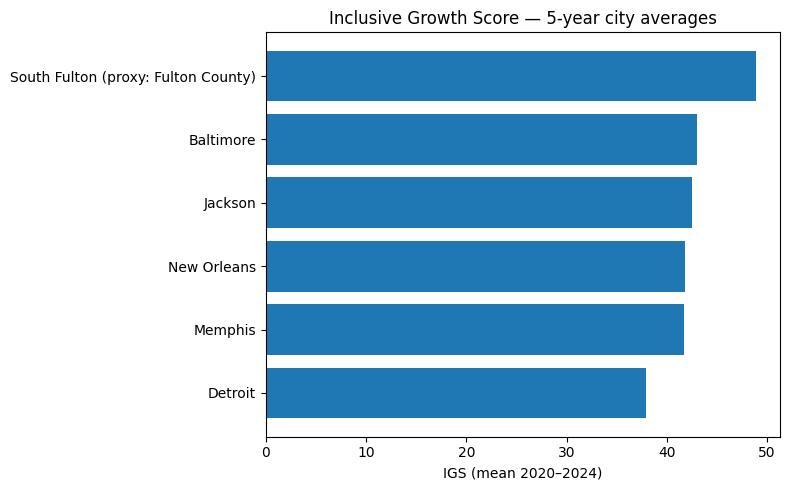

In [9]:
import matplotlib.pyplot as plt

plot_df = final.sort_values("igs_avg_2020_2024", ascending=True)

plt.figure(figsize=(8,5))
plt.barh(plot_df["city"], plot_df["igs_avg_2020_2024"])
plt.xlabel("IGS (mean 2020–2024)")
plt.title("Inclusive Growth Score — 5-year city averages")
plt.tight_layout()
plt.show()


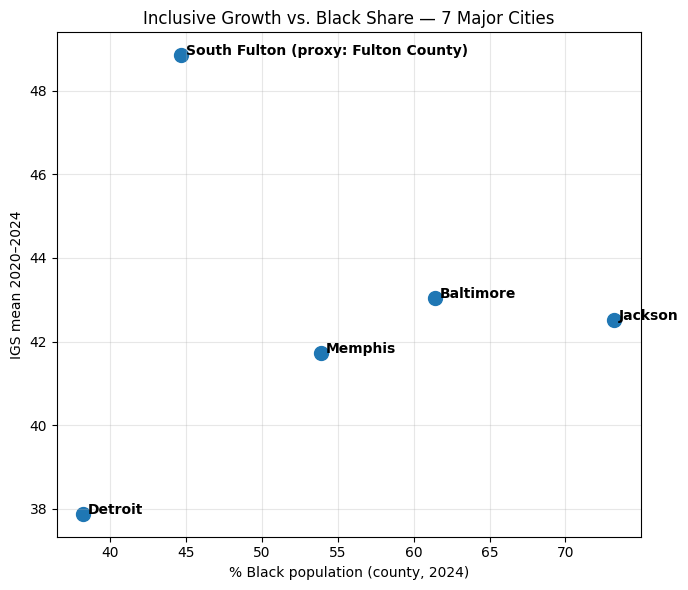

In [11]:
agg = (
    final.groupby("city", as_index=False)
         .agg({"black_pct": "mean", "igs_avg_2020_2024": "mean"})
)

plt.figure(figsize=(7,6))
plt.scatter(agg["black_pct"], agg["igs_avg_2020_2024"], s=100)
for _, r in agg.iterrows():
    plt.text(r["black_pct"]+0.3, r["igs_avg_2020_2024"], r["city"], fontsize=10, weight="bold")
plt.xlabel("% Black population (county, 2024)")
plt.ylabel("IGS mean 2020–2024")
plt.title("Inclusive Growth vs. Black Share — 7 Major Cities")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
